# Clustering analysis

The building energy consumption data shows patterns. We can group them using clustering techniques.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data
consumption_values_raw = pd.read_excel('/Users/changsu/Documents/LESIA/Sammanställning_mätvärden_2023_LESIA.xlsx',
                           sheet_name = "Konsumtion mätvärden")

consumption_values_raw.head()

Anläggning      1     2    3      4      5      6    7      8      9  \
0  2023-01-01 00-01  1.977  3.04  9.0  10.91  3.733   9.96  0.0  2.428  1.076   
1  2023-01-01 01-02  2.022  3.06  9.0  10.91  3.837  10.45  0.0  2.496  1.101   
2  2023-01-01 02-03  2.021  3.07  9.0  10.99  3.834  10.97  0.0  2.494  1.100   
3  2023-01-01 03-04  2.035  3.06  9.0  11.15  3.871   8.88  0.0  2.518  1.108   
4  2023-01-01 04-05  2.009  3.22  9.0  10.80  3.811   9.13  0.0  2.479  1.095   

   ...   287  288   289     290    291    292   293     294    295    296  
0  ...  22.0  1.0  5.45  124.19  7.514  0.823  3.81  112.84  29.52  14.27  
1  ...  24.0  0.0  5.60  126.73  7.707  1.237  3.83  123.10  41.02  14.00  
2  ...  29.0  0.0  4.88  123.10  7.694  0.909  3.86  124.90  34.76  13.97  
3  ...  24.0  1.0  5.25  127.13  7.759  1.071  3.84  128.87  35.83  13.54  
4  ...  24.0  0.0  5.17  126.74  7.697  1.091  3.83  130.12  34.83  13.83  

[5 rows x 293 columns]

In [3]:
# Check the shape of the dataframe
consumption_values_raw.shape

(8760, 293)

## Data preperation

### Step 1: Data preprocessing
Step 1 aims to detect and remove **missing values** and **outliers** in the raw time series dataset.  
First, the missing values are filtered and set to 0.  
Second, the outliers whose values are significantly higher or lower than the normal range should be identified based on a certain threshold. The threshold is set to be Q1 - 1.5IQR for lower values and Q3 + 1.5IQR for upper values (where Q1 and Q3 are the first and third quartiles, respectively, and IQR is an interquartile range between Q3 and Q1), and then labeled as missing values. Then, these missing values were filled by using a simple moving average method with a window size of 3.

### Step 2: Data segmentation
The data segmentation divide the yearly profile (8760 hours electricity consumption data) into 24 hours $\times$ 365 days, meaning daily electricity consumption profile.


### Step 3: Data normalization
Data normalisation is carried out using daily max. For a certain hour of electricity consumption, the normalisation is:    

$x_{normalised} = \Large\frac{x_{raw}}{x_{max}}$  
          
The reason for normalisation is because we care more on the shape of the daily profile which show the electricity consumption pattern, rather than the absolute magnitute.



In [4]:
# Drop the first column, only keep the columns with numerical data
consumption_values_raw.drop(labels='Anläggning', axis=1, inplace=True)
consumption_values_raw.head()

1     2    3      4      5      6    7      8      9      10   ...   287  \
0  1.977  3.04  9.0  10.91  3.733   9.96  0.0  2.428  1.076  13.09  ...  22.0   
1  2.022  3.06  9.0  10.91  3.837  10.45  0.0  2.496  1.101  13.10  ...  24.0   
2  2.021  3.07  9.0  10.99  3.834  10.97  0.0  2.494  1.100  13.35  ...  29.0   
3  2.035  3.06  9.0  11.15  3.871   8.88  0.0  2.518  1.108  13.24  ...  24.0   
4  2.009  3.22  9.0  10.80  3.811   9.13  0.0  2.479  1.095  13.11  ...  24.0   

   288   289     290    291    292   293     294    295    296  
0  1.0  5.45  124.19  7.514  0.823  3.81  112.84  29.52  14.27  
1  0.0  5.60  126.73  7.707  1.237  3.83  123.10  41.02  14.00  
2  0.0  4.88  123.10  7.694  0.909  3.86  124.90  34.76  13.97  
3  1.0  5.25  127.13  7.759  1.071  3.84  128.87  35.83  13.54  
4  0.0  5.17  126.74  7.697  1.091  3.83  130.12  34.83  13.83  

[5 rows x 292 columns]

In [5]:
# Check missing values, return the columns with missing values
consumption_values_raw.columns[consumption_values_raw.isna().any()]

Index([105, 123, 144, 174, 261], dtype='object')

In [6]:
# Look at the missing values in dataframe view
consumption_values_raw.loc[1000:, consumption_values_raw.isna().any()]

105   123    144    174     261
1000  0.634  0.08  1.822    NaN   3.489
1001  0.364  0.09  2.000    NaN   2.696
1002  0.418  0.09  1.872    NaN   2.968
1003  0.931  0.09  2.261    NaN   4.493
1004  1.589  0.08  2.158    NaN   3.527
...     ...   ...    ...    ...     ...
8755  1.791  0.02  2.290  6.974  13.608
8756  1.535  0.02  2.521  6.931  14.409
8757  1.217  0.02  2.657  7.080  13.680
8758  1.198  0.02  2.357  7.017  13.662
8759  2.049  0.02  2.506  7.226  13.579

[7760 rows x 5 columns]

In [7]:
# Fill the missing values using 0
consumption_values_raw_filled = consumption_values_raw.fillna(0)

# Find the outliers in the dataset using IQR method
outliers = pd.DataFrame(index=consumption_values_raw_filled.index,
                        columns=consumption_values_raw_filled.columns)

outliers

1    2    3    4    5    6    7    8    9    10   ...  287  288  289  \
0     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8755  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
8756  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
8757  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
8758  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
8759  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

      290  291  292  293  294  295  296  
0     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...   ...  ...  ...  ...  ...  ...  ...  
8755  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8756  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8757  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8758  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8759  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[8760 rows x 292 columns]

In [8]:
def find_outliers_iqr(df):
    # Find the outliers in the dataset using IQR method
    outliers = pd.DataFrame(index=df.index, columns=df.columns)
    
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
    
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers[column] = (df[column] < lower_bound) | (df[column] > upper_bound)
        
    return outliers


def replace_outliers_with_sma(df, outliers, window_size=3):
    df_replaced = df.copy()
    
    for column in df.columns:
        series = df[column]
        outlier_indices = series[outliers[column]].index
        
        for idx in outlier_indices:
            window_start = max(0, idx - window_size // 2)
            window_end = min(len(series), idx + window_size // 2 + 1)
            window_values = series[window_start:window_end]
            
            non_outlier_values = window_values[~outliers[column][window_start:window_end]]
            
            if len(non_outlier_values) > 0:
                df_replaced.at[idx, column] = non_outlier_values.mean()
            else:
                # Fallback to overall mean if all window values are outliers
                df_replaced.at[idx, column] = series.mean()  
    
    return df_replaced

In [9]:
outliers = find_outliers_iqr(consumption_values_raw_filled)
df_replaced = replace_outliers_with_sma(consumption_values_raw_filled, outliers)

/var/folders/wj/rnnxbxj55kn0jfp29lqz0_k00000gp/T/ipykernel_4766/3163143345.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.24851598173516' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_replaced.at[idx, column] = series.mean()


In [10]:
df_replaced

1     2       3       4      5      6         7      8      9    \
0     1.977  3.04   9.000  10.910  3.733   9.96  0.000000  2.428  1.076   
1     2.022  3.06   9.000  10.910  3.837  10.45  0.000000  2.496  1.101   
2     2.021  3.07   9.000  10.990  3.834  10.97  0.000000  2.494  1.100   
3     2.035  3.06   9.000  11.150  3.871   8.88  0.000000  2.518  1.108   
4     2.009  3.22   9.000  10.800  3.811   9.13  0.000000  2.479  1.095   
...     ...   ...     ...     ...    ...    ...       ...    ...    ...   
8755  1.529  3.48  14.357  10.218  3.776   9.03  1.248126  2.502  1.136   
8756  1.531  3.46  14.364  10.180  3.783   9.58  1.248126  2.503  1.137   
8757  1.502  3.56  14.339  10.864  3.810   9.28  1.248126  2.521  1.142   
8758  1.492  3.43  14.192  10.829  3.783   9.06  1.248126  2.503  1.109   
8759  1.389  3.45  14.271  10.363  3.807   9.15  1.248126  2.490  0.869   

        10   ...    287    288   289     290    291    292   293     294  \
0     13.09  ...  22.00  1.000  5.45  124.19  7.514  0.823  3.81  112.84   
1     13.10  ...  24.00  0.000  5.60  126.73  7.707  1.237  3.83  123.10   
2     13.35  ...  29.00  0.000  4.88  123.10  7.694  0.909  3.86  124.90   
3     13.24  ...  24.00  1.000  5.25  127.13  7.759  1.071  3.84  128.87   
4     13.11  ...  24.00  0.000  5.17  126.74  7.697  1.091  3.83  130.12   
...     ...  ...    ...    ...   ...     ...    ...    ...   ...     ...   
8755  13.30  ...  23.50  0.267  7.07   47.71  7.308  1.202  3.92  126.82   
8756  13.13  ...  25.35  0.440  8.91   47.34  7.315  1.305  3.90  125.44   
8757  13.05  ...  30.86  0.334  8.90   46.00  7.355  1.454  3.92  125.02   
8758  12.93  ...  38.14  0.441  9.19   45.68  7.240  1.169  4.00  121.35   
8759  13.06  ...  27.30  0.281  7.97   45.99  7.250  1.369  4.03  121.50   

        295    296  
0     29.52  14.27  
1     41.02  14.00  
2     34.76  13.97  
3     35.83  13.54  
4     34.83  13.83  
...     ...    ...  
8755  33.39  16.21  
8756  55.21  16.82  
8757  26.75  16.78  
8758  47.58  16.35  
8759  33.64  16.28  

[8760 rows x 292 columns]

In [11]:
# Data segmentation
# Create multi-index on days and hours
days = np.repeat(np.arange(1, 366), 24)
hours = np.tile(np.arange(0, 24), 365)
multi_index = pd.MultiIndex.from_arrays([days, hours], names=['Day', 'Hour'])
df_replaced.index = multi_index
df_replaced

1     2       3       4      5      6         7      8      9    \
Day Hour                                                                      
1   0     1.977  3.04   9.000  10.910  3.733   9.96  0.000000  2.428  1.076   
    1     2.022  3.06   9.000  10.910  3.837  10.45  0.000000  2.496  1.101   
    2     2.021  3.07   9.000  10.990  3.834  10.97  0.000000  2.494  1.100   
    3     2.035  3.06   9.000  11.150  3.871   8.88  0.000000  2.518  1.108   
    4     2.009  3.22   9.000  10.800  3.811   9.13  0.000000  2.479  1.095   
...         ...   ...     ...     ...    ...    ...       ...    ...    ...   
365 19    1.529  3.48  14.357  10.218  3.776   9.03  1.248126  2.502  1.136   
    20    1.531  3.46  14.364  10.180  3.783   9.58  1.248126  2.503  1.137   
    21    1.502  3.56  14.339  10.864  3.810   9.28  1.248126  2.521  1.142   
    22    1.492  3.43  14.192  10.829  3.783   9.06  1.248126  2.503  1.109   
    23    1.389  3.45  14.271  10.363  3.807   9.15  1.248126  2.490  0.869   

            10   ...    287    288   289     290    291    292   293     294  \
Day Hour         ...                                                           
1   0     13.09  ...  22.00  1.000  5.45  124.19  7.514  0.823  3.81  112.84   
    1     13.10  ...  24.00  0.000  5.60  126.73  7.707  1.237  3.83  123.10   
    2     13.35  ...  29.00  0.000  4.88  123.10  7.694  0.909  3.86  124.90   
    3     13.24  ...  24.00  1.000  5.25  127.13  7.759  1.071  3.84  128.87   
    4     13.11  ...  24.00  0.000  5.17  126.74  7.697  1.091  3.83  130.12   
...         ...  ...    ...    ...   ...     ...    ...    ...   ...     ...   
365 19    13.30  ...  23.50  0.267  7.07   47.71  7.308  1.202  3.92  126.82   
    20    13.13  ...  25.35  0.440  8.91   47.34  7.315  1.305  3.90  125.44   
    21    13.05  ...  30.86  0.334  8.90   46.00  7.355  1.454  3.92  125.02   
    22    12.93  ...  38.14  0.441  9.19   45.68  7.240  1.169  4.00  121.35   
    23    13.06  ...  27.30  0.281  7.97   45.99  7.250  1.369  4.03  121.50   

            295    296  
Day Hour                
1   0     29.52  14.27  
    1     41.02  14.00  
    2     34.76  13.97  
    3     35.83  13.54  
    4     34.83  13.83  
...         ...    ...  
365 19    33.39  16.21  
    20    55.21  16.82  
    21    26.75  16.78  
    22    47.58  16.35  
    23    33.64  16.28  

[8760 rows x 292 columns]

In [57]:
df_replaced

1     2       3       4      5      6         7      8      9    \
Day Hour                                                                      
1   0     1.977  3.04   9.000  10.910  3.733   9.96  0.000000  2.428  1.076   
    1     2.022  3.06   9.000  10.910  3.837  10.45  0.000000  2.496  1.101   
    2     2.021  3.07   9.000  10.990  3.834  10.97  0.000000  2.494  1.100   
    3     2.035  3.06   9.000  11.150  3.871   8.88  0.000000  2.518  1.108   
    4     2.009  3.22   9.000  10.800  3.811   9.13  0.000000  2.479  1.095   
...         ...   ...     ...     ...    ...    ...       ...    ...    ...   
365 19    1.529  3.48  14.357  10.218  3.776   9.03  1.248126  2.502  1.136   
    20    1.531  3.46  14.364  10.180  3.783   9.58  1.248126  2.503  1.137   
    21    1.502  3.56  14.339  10.864  3.810   9.28  1.248126  2.521  1.142   
    22    1.492  3.43  14.192  10.829  3.783   9.06  1.248126  2.503  1.109   
    23    1.389  3.45  14.271  10.363  3.807   9.15  1.248126  2.490  0.869   

            10   ...    287    288   289     290    291    292   293     294  \
Day Hour         ...                                                           
1   0     13.09  ...  22.00  1.000  5.45  124.19  7.514  0.823  3.81  112.84   
    1     13.10  ...  24.00  0.000  5.60  126.73  7.707  1.237  3.83  123.10   
    2     13.35  ...  29.00  0.000  4.88  123.10  7.694  0.909  3.86  124.90   
    3     13.24  ...  24.00  1.000  5.25  127.13  7.759  1.071  3.84  128.87   
    4     13.11  ...  24.00  0.000  5.17  126.74  7.697  1.091  3.83  130.12   
...         ...  ...    ...    ...   ...     ...    ...    ...   ...     ...   
365 19    13.30  ...  23.50  0.267  7.07   47.71  7.308  1.202  3.92  126.82   
    20    13.13  ...  25.35  0.440  8.91   47.34  7.315  1.305  3.90  125.44   
    21    13.05  ...  30.86  0.334  8.90   46.00  7.355  1.454  3.92  125.02   
    22    12.93  ...  38.14  0.441  9.19   45.68  7.240  1.169  4.00  121.35   
    23    13.06  ...  27.30  0.281  7.97   45.99  7.250  1.369  4.03  121.50   

            295    296  
Day Hour                
1   0     29.52  14.27  
    1     41.02  14.00  
    2     34.76  13.97  
    3     35.83  13.54  
    4     34.83  13.83  
...         ...    ...  
365 19    33.39  16.21  
    20    55.21  16.82  
    21    26.75  16.78  
    22    47.58  16.35  
    23    33.64  16.28  

[8760 rows x 292 columns]

In [58]:
# Data normalisation, normalise to daily max
def normalisation(df):
    df_normalised = df / df.max()
    return df_normalised

df_normalised = df_replaced.groupby('Day').apply(normalisation)
df_normalised

1         2         3         4         5         6    7    \
Day Day Hour                                                                    
1   1   0     0.902740  0.944099  0.642857  0.215400  0.964350  0.679863  NaN   
        1     0.923288  0.950311  0.642857  0.215400  0.991217  0.713311  NaN   
        2     0.922831  0.953416  0.642857  0.216979  0.990442  0.748805  NaN   
        3     0.929224  0.950311  0.642857  0.220138  1.000000  0.606143  NaN   
        4     0.917352  1.000000  0.642857  0.213228  0.984500  0.623208  NaN   
...                ...       ...       ...       ...       ...       ...  ...   
365 365 19    0.998694  0.969359  0.998262  0.915181  0.990296  0.910282  1.0   
        20    1.000000  0.963788  0.998748  0.911778  0.992132  0.965726  1.0   
        21    0.981058  0.991643  0.997010  0.973041  0.999213  0.935484  1.0   
        22    0.974526  0.955432  0.986789  0.969906  0.992132  0.913306  1.0   
        23    0.907250  0.961003  0.992282  0.928168  0.998426  0.922379  1.0   

                   8         9         10   ...       287       288       289  \
Day Day Hour                                ...                                 
1   1   0     0.964257  0.819497  0.839103  ...  0.550000  0.500000  0.361886   
        1     0.991263  0.838538  0.839744  ...  0.600000  0.000000  0.371846   
        2     0.990469  0.837776  0.855769  ...  0.725000  0.000000  0.324037   
        3     1.000000  0.843869  0.848718  ...  0.600000  0.500000  0.348606   
        4     0.984512  0.833968  0.840385  ...  0.600000  0.000000  0.343293   
...                ...       ...       ...  ...       ...       ...       ...   
365 365 19    0.992463  0.994746  0.950679  ...  0.616151  0.571734  0.402620   
        20    0.992860  0.995622  0.938528  ...  0.664657  0.942184  0.507403   
        21    1.000000  1.000000  0.932809  ...  0.809124  0.715203  0.506834   
        22    0.992860  0.971103  0.924232  ...  1.000000  0.944325  0.523349   
        23    0.987703  0.760946  0.933524  ...  0.715784  0.601713  0.453872   

                   290       291       292       293       294       295  \
Day Day Hour                                                               
1   1   0     0.772374  0.968424  0.609630  0.987047  0.803646  0.359386   
        1     0.788171  0.993298  0.916296  0.992228  0.876718  0.499391   
        2     0.765595  0.991623  0.673333  1.000000  0.889538  0.423180   
        3     0.790659  1.000000  0.793333  0.994819  0.917812  0.436206   
        4     0.788233  0.992009  0.808148  0.992228  0.926715  0.424032   
...                ...       ...       ...       ...       ...       ...   
365 365 19    1.000000  0.993610  0.633966  0.963145  0.820948  0.436642   
        20    0.992245  0.994562  0.688291  0.958231  0.812015  0.721982   
        21    0.964158  1.000000  0.766878  0.963145  0.809296  0.349810   
        22    0.957451  0.984364  0.616561  0.982801  0.785539  0.622205   
        23    0.963949  0.985724  0.722046  0.990172  0.786510  0.439911   

                   296  
Day Day Hour            
1   1   0     0.976728  
        1     0.958248  
        2     0.956194  
        3     0.926762  
        4     0.946612  
...                ...  
365 365 19    0.963734  
        20    1.000000  
        21    0.997622  
        22    0.972057  
        23    0.967895  

[8760 rows x 292 columns]

In [60]:
df_normalised.reset_index(level=0, drop=True, inplace=True)
df_normalised

1         2         3         4         5         6    7    \
Day Hour                                                                    
1   0     0.902740  0.944099  0.642857  0.215400  0.964350  0.679863  NaN   
    1     0.923288  0.950311  0.642857  0.215400  0.991217  0.713311  NaN   
    2     0.922831  0.953416  0.642857  0.216979  0.990442  0.748805  NaN   
    3     0.929224  0.950311  0.642857  0.220138  1.000000  0.606143  NaN   
    4     0.917352  1.000000  0.642857  0.213228  0.984500  0.623208  NaN   
...            ...       ...       ...       ...       ...       ...  ...   
365 19    0.998694  0.969359  0.998262  0.915181  0.990296  0.910282  1.0   
    20    1.000000  0.963788  0.998748  0.911778  0.992132  0.965726  1.0   
    21    0.981058  0.991643  0.997010  0.973041  0.999213  0.935484  1.0   
    22    0.974526  0.955432  0.986789  0.969906  0.992132  0.913306  1.0   
    23    0.907250  0.961003  0.992282  0.928168  0.998426  0.922379  1.0   

               8         9         10   ...       287       288       289  \
Day Hour                                ...                                 
1   0     0.964257  0.819497  0.839103  ...  0.550000  0.500000  0.361886   
    1     0.991263  0.838538  0.839744  ...  0.600000  0.000000  0.371846   
    2     0.990469  0.837776  0.855769  ...  0.725000  0.000000  0.324037   
    3     1.000000  0.843869  0.848718  ...  0.600000  0.500000  0.348606   
    4     0.984512  0.833968  0.840385  ...  0.600000  0.000000  0.343293   
...            ...       ...       ...  ...       ...       ...       ...   
365 19    0.992463  0.994746  0.950679  ...  0.616151  0.571734  0.402620   
    20    0.992860  0.995622  0.938528  ...  0.664657  0.942184  0.507403   
    21    1.000000  1.000000  0.932809  ...  0.809124  0.715203  0.506834   
    22    0.992860  0.971103  0.924232  ...  1.000000  0.944325  0.523349   
    23    0.987703  0.760946  0.933524  ...  0.715784  0.601713  0.453872   

               290       291       292       293       294       295       296  
Day Hour                                                                        
1   0     0.772374  0.968424  0.609630  0.987047  0.803646  0.359386  0.976728  
    1     0.788171  0.993298  0.916296  0.992228  0.876718  0.499391  0.958248  
    2     0.765595  0.991623  0.673333  1.000000  0.889538  0.423180  0.956194  
    3     0.790659  1.000000  0.793333  0.994819  0.917812  0.436206  0.926762  
    4     0.788233  0.992009  0.808148  0.992228  0.926715  0.424032  0.946612  
...            ...       ...       ...       ...       ...       ...       ...  
365 19    1.000000  0.993610  0.633966  0.963145  0.820948  0.436642  0.963734  
    20    0.992245  0.994562  0.688291  0.958231  0.812015  0.721982  1.000000  
    21    0.964158  1.000000  0.766878  0.963145  0.809296  0.349810  0.997622  
    22    0.957451  0.984364  0.616561  0.982801  0.785539  0.622205  0.972057  
    23    0.963949  0.985724  0.722046  0.990172  0.786510  0.439911  0.967895  

[8760 rows x 292 columns]

In [121]:
df_normalised.loc[1][1]

Hour
0     0.902740
1     0.923288
2     0.922831
3     0.929224
4     0.917352
5     0.968493
6     0.979452
7     0.976712
8     0.447489
9     0.001826
10    0.001826
11    0.001370
12    0.001826
13    0.001826
14    0.001826
15    0.053881
16    0.981279
17    0.984932
18    0.989041
19    1.000000
20    0.995434
21    0.975342
22    0.963927
23    0.923744
Name: 1, dtype: float64

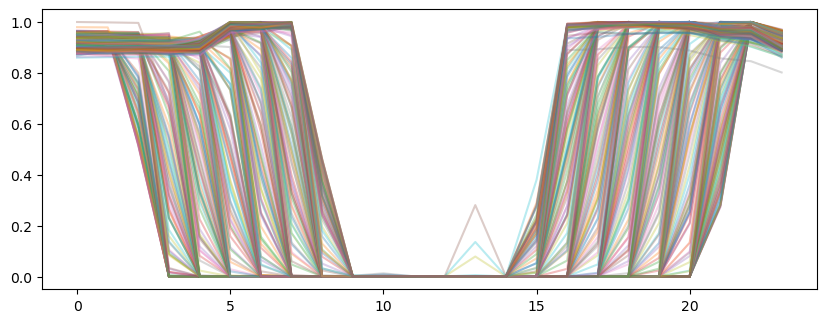

In [124]:
# Visualise the first building in the dataset

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(2, 1, 1)

for day in range(1, 366):
    ax.plot(df_normalised.loc[day].index.get_level_values('Hour'), df_normalised.loc[day][1],
            label=f'Day {day}', alpha=0.3)

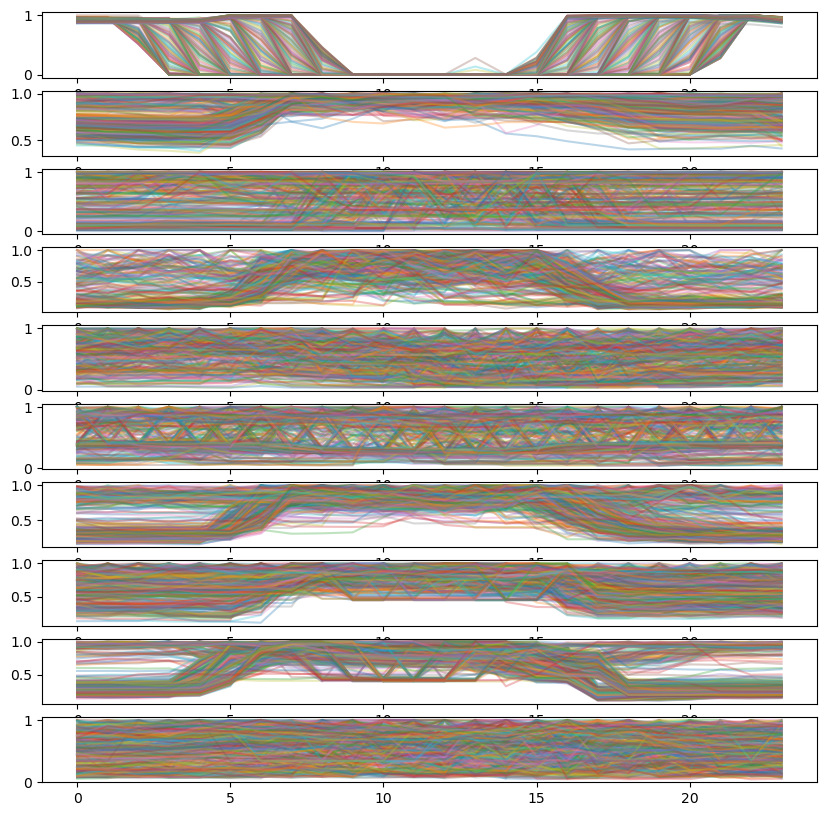

In [128]:
# Visualise 10 random buildings(anläggningar) in the dataset

fig = plt.figure(figsize=(10,10))

for i in range(1, 11):
    ax = fig.add_subplot(10,1,i)

    for day in range(1, 366):
        ax.plot(df_normalised.loc[day].index.get_level_values('Hour'), 
                df_normalised.loc[day][i + 10*(i-1)],
                label=f'Day {day}', alpha=0.3)

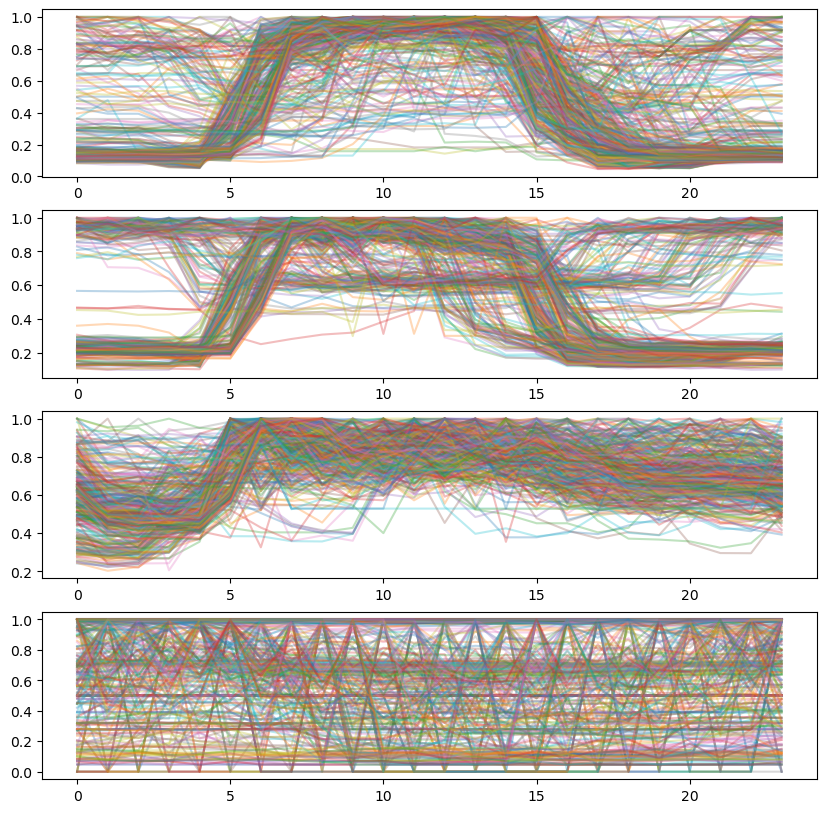

In [143]:
# Visualise the 2 interesting companies in the dataset: SLP and Scania

# Company SLP and Scania are potential stakeholders that could get more involved into energy 
# conmmunity interactions, so we particularly look at these two buildings

# SLP: Address ->    Vevgatan 1, Viaredsvägen 32f.b, Prognosgatan 3, Stormgatan 9
#      Anläggning -> 63        , 70                , ?             , ?
# Scania: Address -> Viaredsvägen 6
#         Anläggning -> 94, 288

fig = plt.figure(figsize=(10,10))

anläggningar = [63, 70, 94, 288]

for i, anläggning in zip(range(1, 5), anläggningar):
    ax = fig.add_subplot(4,1,i)

    for day in range(1, 366):
        ax.plot(df_normalised.loc[day].index.get_level_values('Hour'),
                df_normalised.loc[day][anläggning], 
                label=f'Day {day}', alpha=0.3)

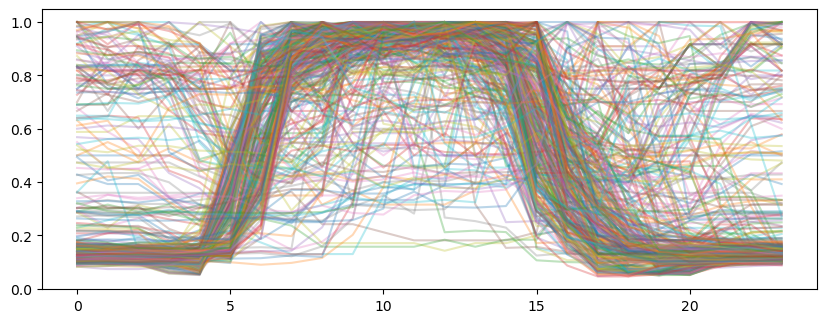

In [134]:
# Visualise building anläggning 63 in the dataset

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(2, 1, 1)

for day in range(1, 366):
    ax.plot(df_normalised.loc[day].index.get_level_values('Hour'), df_normalised.loc[day][63],
            label=f'Day {day}', alpha=0.3)

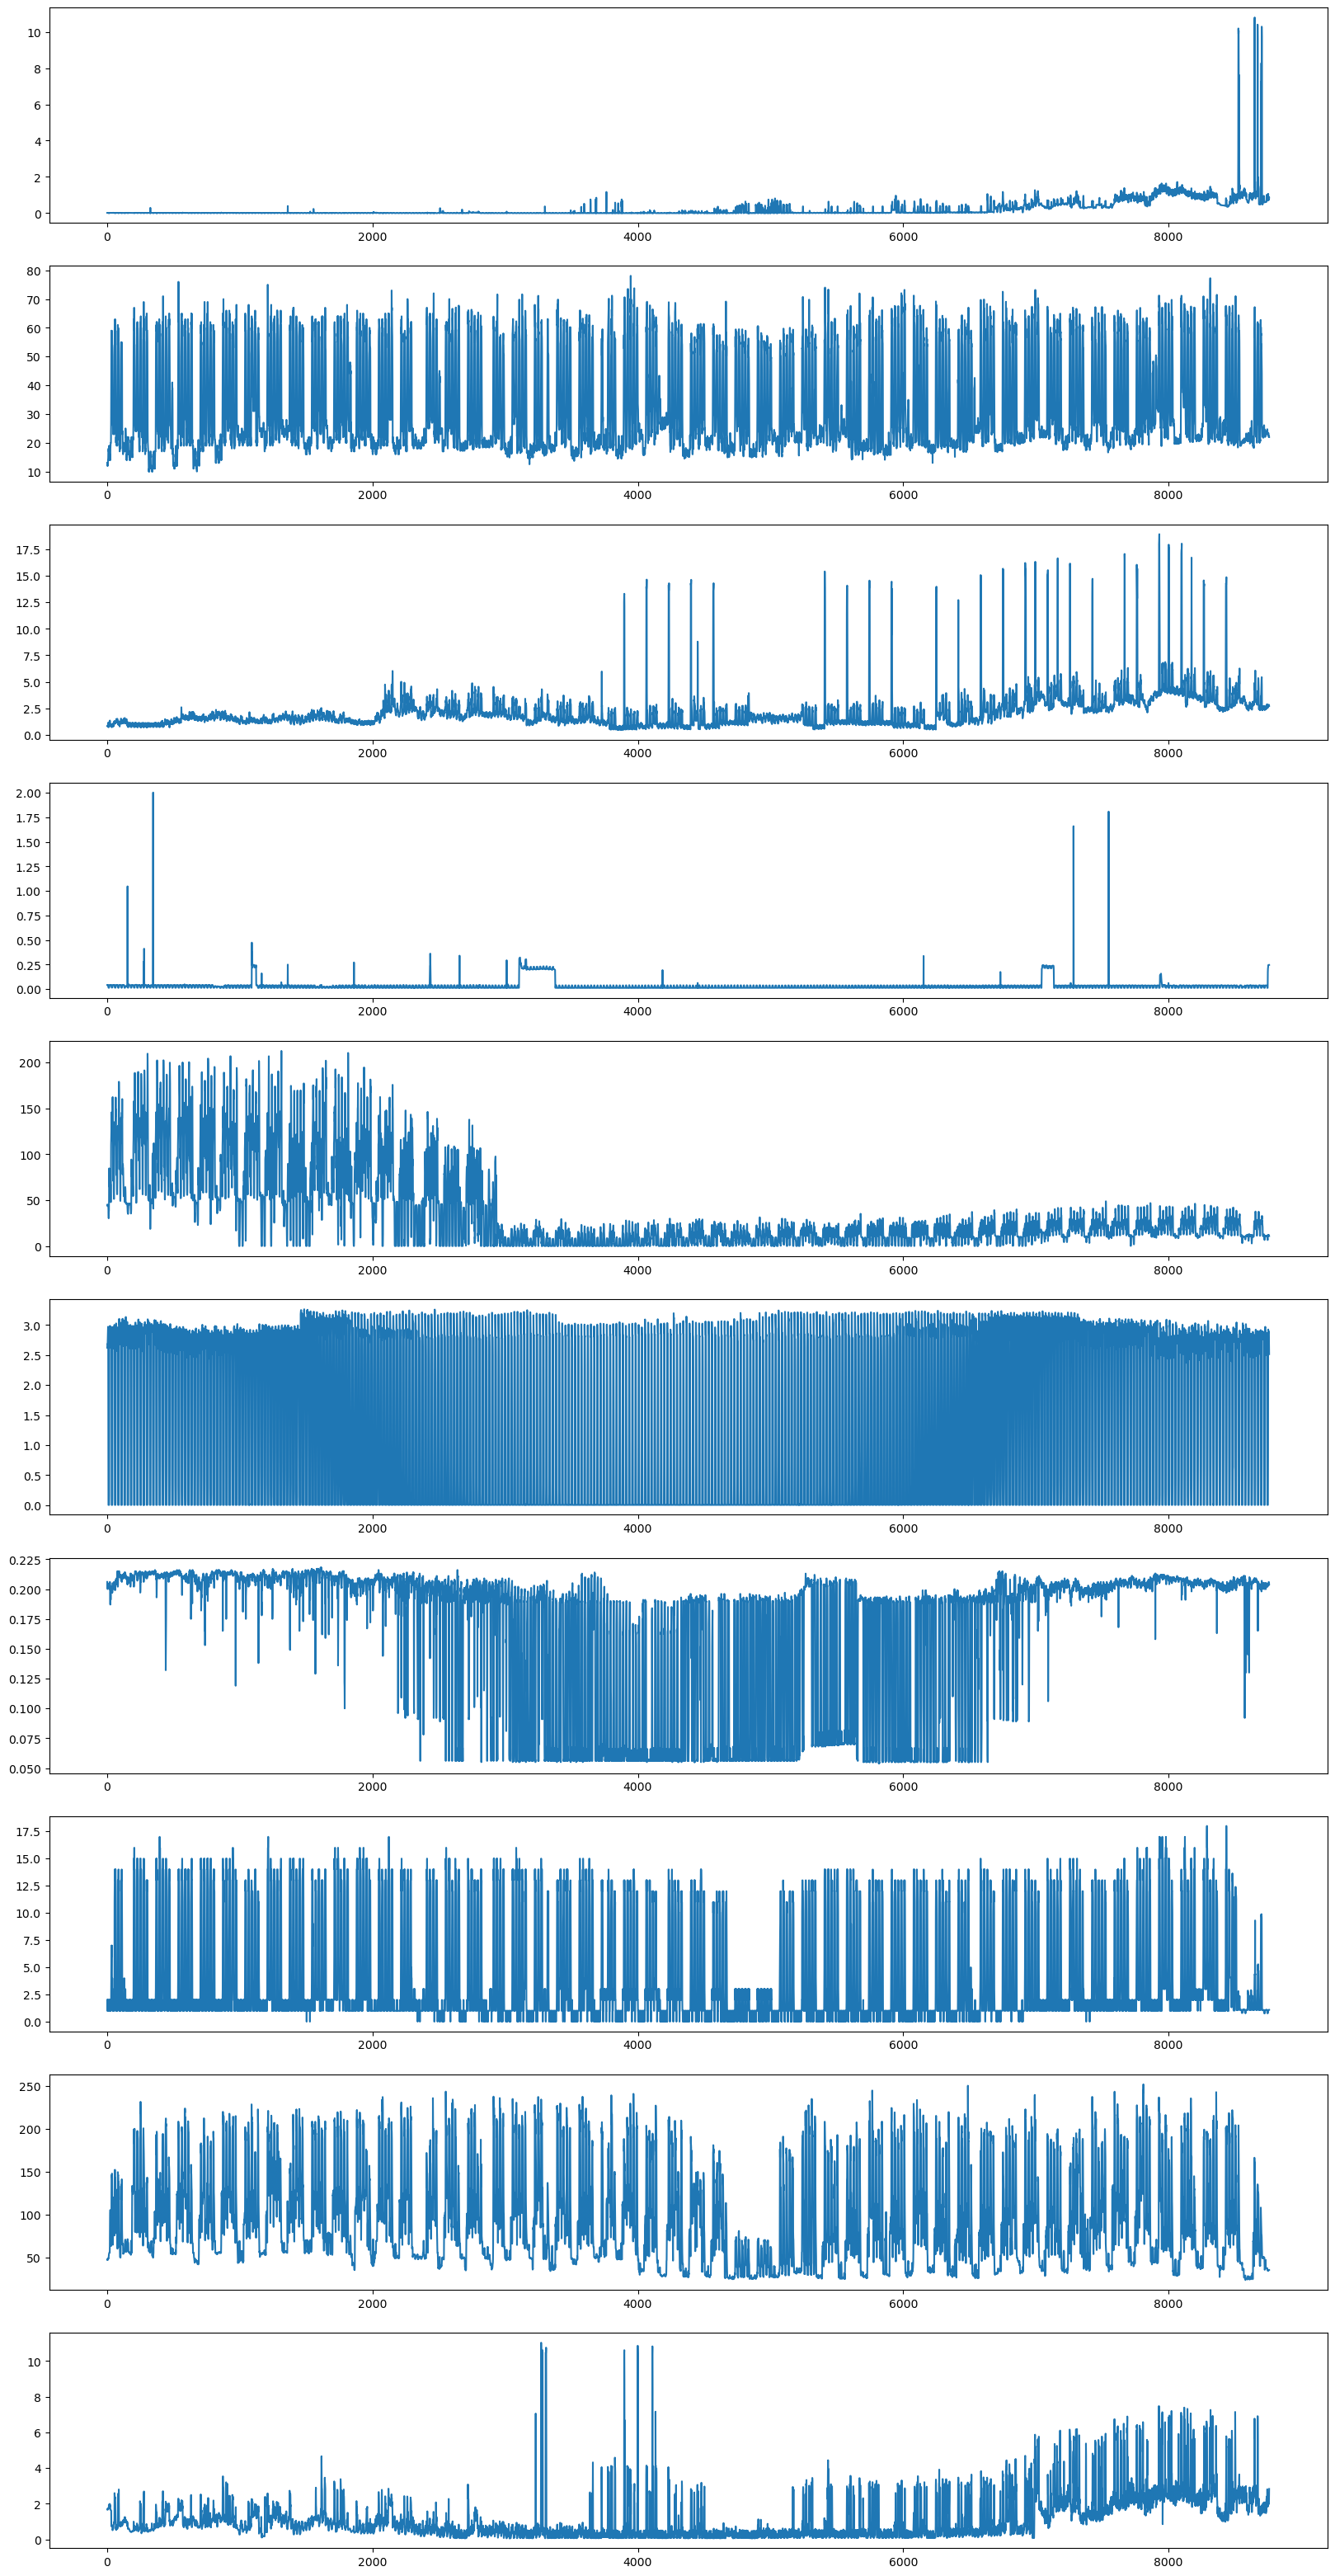

In [13]:
# Visualise 10 random buildings on the absolute electricity consumption values in the dataset, in # 8760 hours instead of segmented and normalised.

fig = plt.figure(figsize=(20,40))

for i in range(1, 11):
    ax = fig.add_subplot(10,1,i)
    ax.plot(consumption_values_raw.index, consumption_values_raw.iloc[:, 1 + i*25])
    
plt.show()

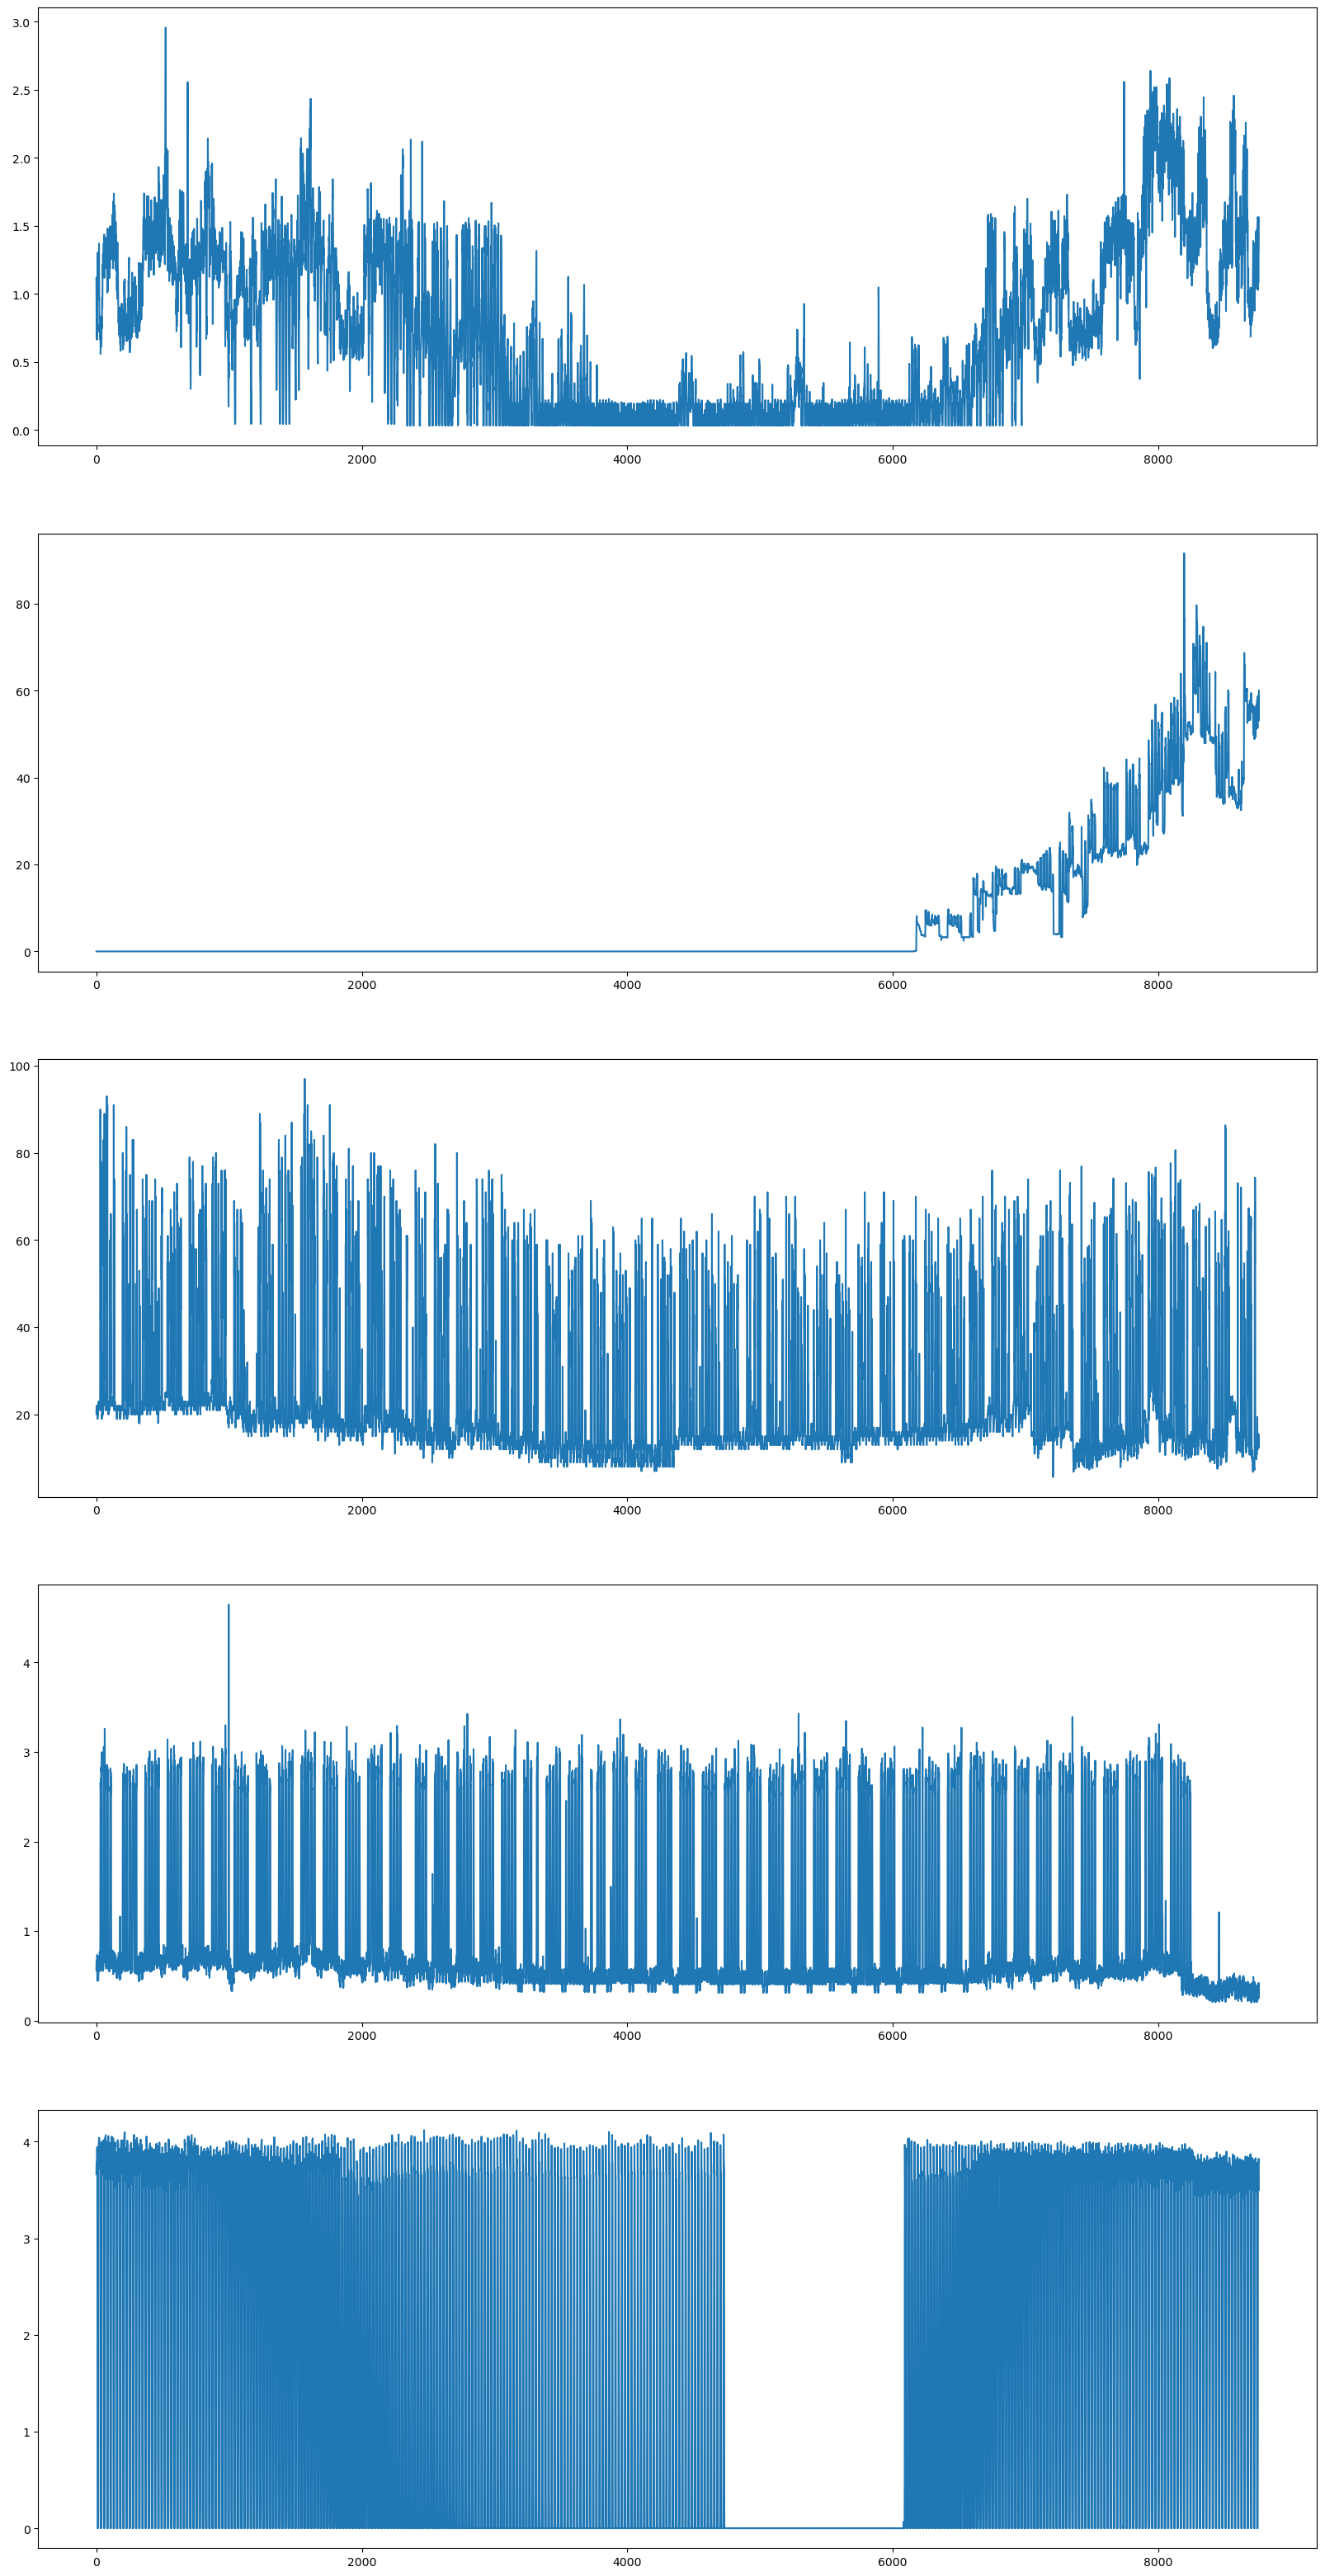

In [14]:
fig = plt.figure(figsize=(20,40))

for i, j in enumerate([105, 123, 144, 174, 261]):
    ax = fig.add_subplot(5,1,i+1)
    ax.plot(consumption_values_raw.index, consumption_values_raw.iloc[:, j])
    
plt.show()

## Clustering

To identify representative load profile (or typcial load profile). The clustering consists of inter-building culstering which focuses on one single building, and intra-building clustering which focuses on all the buildings in Viared area.

### Step 1: Feature definition
According to reveiewed literatures, there are two ways to define the features of daily load profile for clustering.  

*  Using the 24 hours, which means no extra actions on processing the daily profiles.
*  Using the segmented profiles, as shown in the figure below: 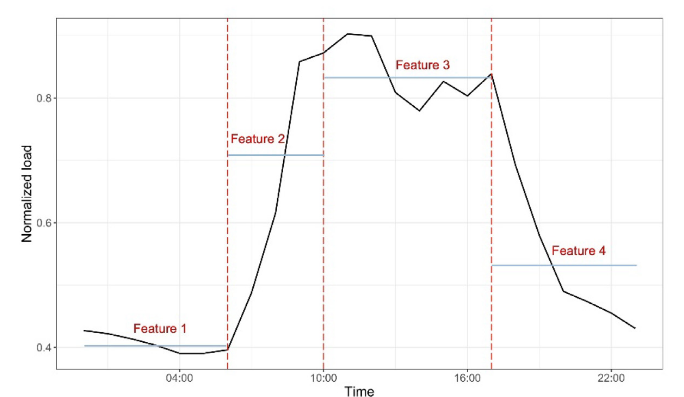


### Step 2: K-means clustering

*  The Calinski-Harabasz score was plotted to determine the optimal number of clusters.
*  Use K

In [149]:
#df_normalised[63].to_csv('./Load_profiles/anläggning63.csv')
df_normalised[70].to_csv('./Load_profiles/anläggning70.csv')
df_normalised[94].to_csv('./Load_profiles/anläggning94.csv')
df_normalised[288].to_csv('./Load_profiles/anläggning288.csv')

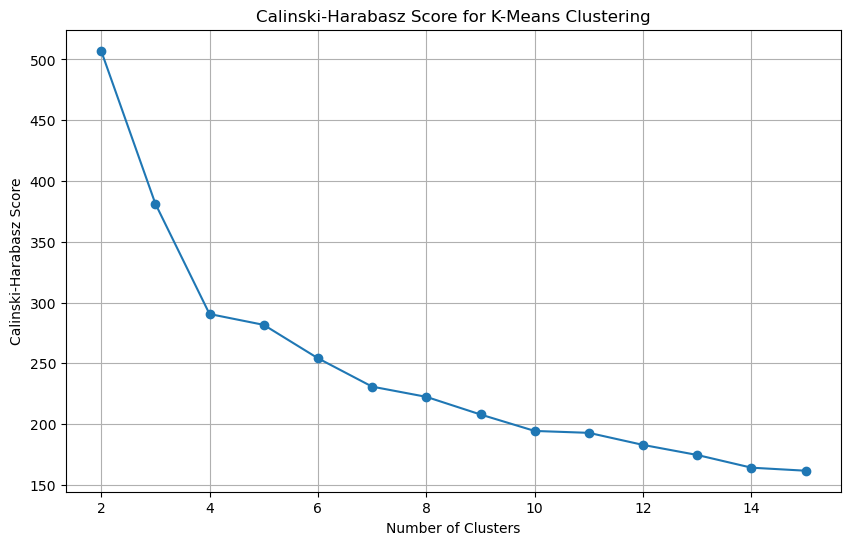

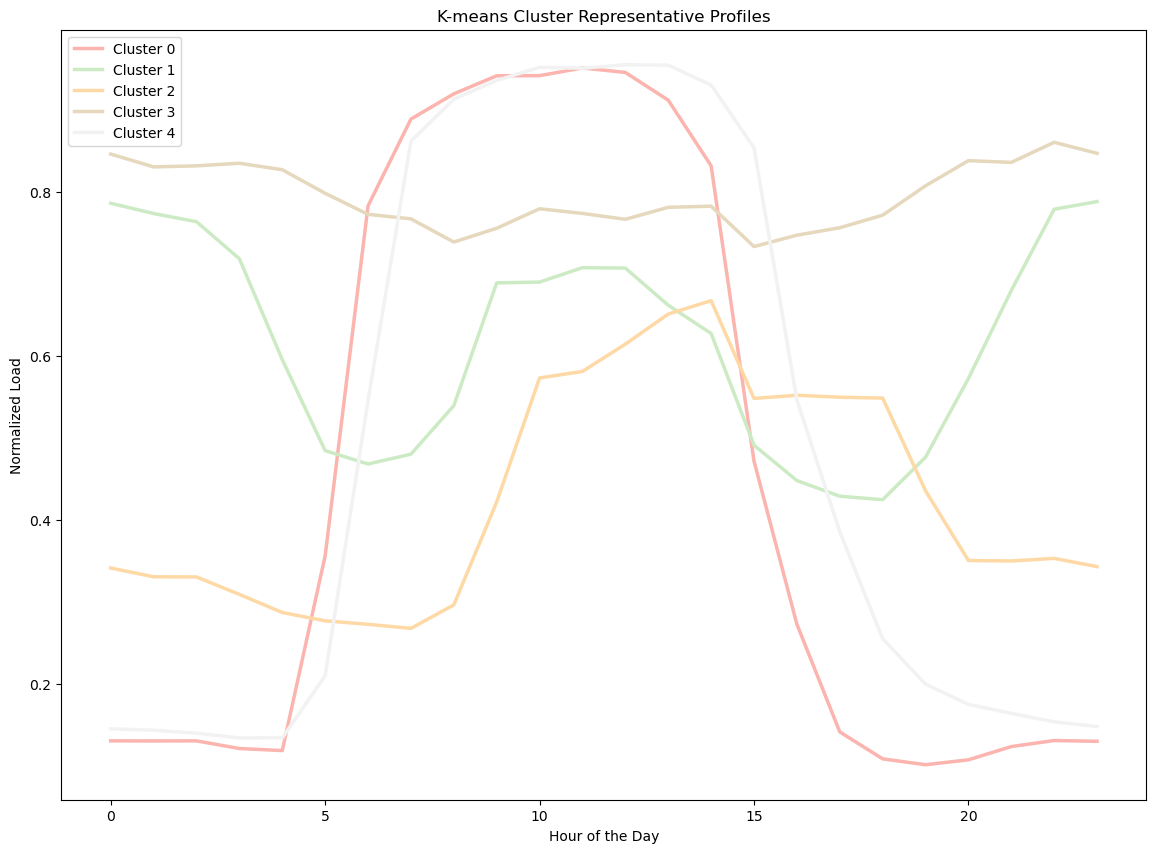

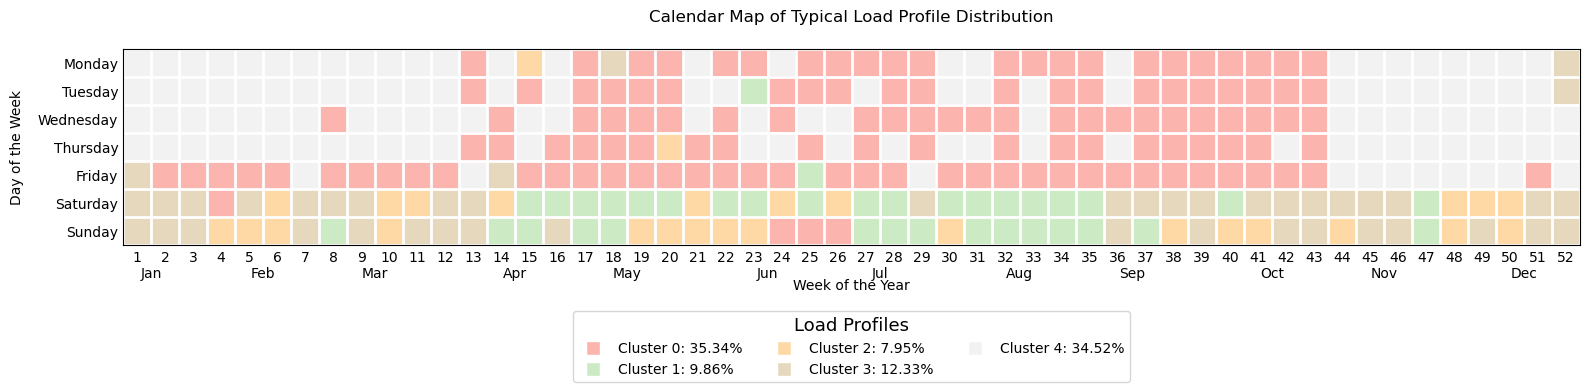

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans
import numpy as np

# Load the data
file_path_63 = './Load_profiles/anläggning63.csv'  # Change this to the correct path
data_63 = pd.read_csv(file_path_63)

# Reshape the data to have 365 rows and 24 columns
data_pivot_63 = data_63.pivot(index='Day', columns='Hour', values='63')

# Find the optimal number of clusters
max_k = 15

def find_optimal_clusters(data, max_k):
    scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = calinski_harabasz_score(data, labels)
        scores.append(score)
    return scores

scores_63 = find_optimal_clusters(data_pivot_63.iloc[:, :24], max_k)

# Plot the scores to find the elbow point
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k + 1), scores_63, marker='o')
plt.title('Calinski-Harabasz Score for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)
plt.show()

# Determine the optimal number of clusters
k_optimal_63 = 5  # Chosen based on the elbow point in the plot

# Apply k-means clustering with the optimal number of clusters
kmeans_63 = KMeans(n_clusters=k_optimal_63, random_state=42)
data_pivot_63['Cluster_KMeans'] = kmeans_63.fit_predict(data_pivot_63.iloc[:, :24])

# Calculate the mean load profile for each cluster
kmeans_profiles_63 = data_pivot_63.groupby('Cluster_KMeans').mean().iloc[:, :24]

# Plot the representative profiles for k-means clusters with Pastel1 colormap
plt.figure(figsize=(14, 10))
colors = plt.cm.Pastel1(np.linspace(0, 1, k_optimal_63))

for cluster in kmeans_profiles_63.index:
    plt.plot(kmeans_profiles_63.columns, kmeans_profiles_63.loc[cluster], color=colors[cluster], label=f'Cluster {cluster}', linewidth=2.5)

plt.title('K-means Cluster Representative Profiles')
plt.xlabel('Hour of the Day')
plt.ylabel('Normalized Load')
plt.legend()
plt.show()

# Prepare the data for the calendar heatmap
data_pivot_63['Date'] = pd.date_range(start='2023-01-01', periods=365)
data_pivot_63['WeekOfYear'] = data_pivot_63['Date'].dt.isocalendar().week
data_pivot_63['DayOfWeek'] = data_pivot_63['Date'].dt.dayofweek

# Create a matrix for the heatmap
heatmap_data_63 = pd.pivot_table(data_pivot_63, values='Cluster_KMeans', index='DayOfWeek', columns='WeekOfYear')

# Generate the calendar heatmap with the specified requirements
fig, ax = plt.subplots(figsize=(16, 10))

# Create the heatmap with squared cells
cmap = mcolors.ListedColormap(plt.cm.Pastel1(np.linspace(0, 1, k_optimal_63)))
heatmap = ax.imshow(heatmap_data_63, cmap=cmap, aspect='equal', interpolation='nearest')

# Remove ticks but keep tick labels
ax.tick_params(axis='x', which='both', length=0)
ax.tick_params(axis='y', which='both', length=0)

# Add horizontal and vertical grid lines
ax.set_xticks(np.arange(-.5, heatmap_data_63.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, heatmap_data_63.shape[0], 1), minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)
ax.tick_params(which='minor', size=0)

# Remove other grid lines
ax.grid(False)

# Set the labels and title
ax.set_title('Calendar Map of Typical Load Profile Distribution', pad=20)
ax.set_xlabel('Week of the Year', labelpad=10)
ax.set_ylabel('Day of the Week', labelpad=10)

# Set the y-axis labels to day names
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax.set_yticks(np.arange(7))
ax.set_yticklabels(days)

# Set the x-axis labels to week numbers
weeks = np.arange(1, 53)
ax.set_xticks(np.arange(52))
ax.set_xticklabels(weeks)

# Add month names below the weeks
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_positions = [0, 4, 8, 13, 17, 22, 26, 31, 35, 40, 44, 49]
for pos, month in zip(month_positions, months):
    ax.text(pos + 0.5, 7.5, month, ha='center', va='center')

# Count the frequency of each cluster
cluster_counts_63 = data_pivot_63['Cluster_KMeans'].value_counts(normalize=True).sort_index()
cluster_labels_63 = [f"Cluster {i}: {cluster_counts_63[i]:.2%}" for i in cluster_counts_63.index]

# Add legend with reduced size by 30%
legend_handles_63 = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=cmap(i), markersize=10) for i in cluster_counts_63.index]
legend = ax.legend(legend_handles_63, cluster_labels_63, title='Load Profiles', title_fontsize='13', fontsize='10', loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.2)
plt.show()


In [151]:
df_replaced

1     2       3       4      5      6         7      8      9    \
Day Hour                                                                      
1   0     1.977  3.04   9.000  10.910  3.733   9.96  0.000000  2.428  1.076   
    1     2.022  3.06   9.000  10.910  3.837  10.45  0.000000  2.496  1.101   
    2     2.021  3.07   9.000  10.990  3.834  10.97  0.000000  2.494  1.100   
    3     2.035  3.06   9.000  11.150  3.871   8.88  0.000000  2.518  1.108   
    4     2.009  3.22   9.000  10.800  3.811   9.13  0.000000  2.479  1.095   
...         ...   ...     ...     ...    ...    ...       ...    ...    ...   
365 19    1.529  3.48  14.357  10.218  3.776   9.03  1.248126  2.502  1.136   
    20    1.531  3.46  14.364  10.180  3.783   9.58  1.248126  2.503  1.137   
    21    1.502  3.56  14.339  10.864  3.810   9.28  1.248126  2.521  1.142   
    22    1.492  3.43  14.192  10.829  3.783   9.06  1.248126  2.503  1.109   
    23    1.389  3.45  14.271  10.363  3.807   9.15  1.248126  2.490  0.869   

            10   ...    287    288   289     290    291    292   293     294  \
Day Hour         ...                                                           
1   0     13.09  ...  22.00  1.000  5.45  124.19  7.514  0.823  3.81  112.84   
    1     13.10  ...  24.00  0.000  5.60  126.73  7.707  1.237  3.83  123.10   
    2     13.35  ...  29.00  0.000  4.88  123.10  7.694  0.909  3.86  124.90   
    3     13.24  ...  24.00  1.000  5.25  127.13  7.759  1.071  3.84  128.87   
    4     13.11  ...  24.00  0.000  5.17  126.74  7.697  1.091  3.83  130.12   
...         ...  ...    ...    ...   ...     ...    ...    ...   ...     ...   
365 19    13.30  ...  23.50  0.267  7.07   47.71  7.308  1.202  3.92  126.82   
    20    13.13  ...  25.35  0.440  8.91   47.34  7.315  1.305  3.90  125.44   
    21    13.05  ...  30.86  0.334  8.90   46.00  7.355  1.454  3.92  125.02   
    22    12.93  ...  38.14  0.441  9.19   45.68  7.240  1.169  4.00  121.35   
    23    13.06  ...  27.30  0.281  7.97   45.99  7.250  1.369  4.03  121.50   

            295    296  
Day Hour                
1   0     29.52  14.27  
    1     41.02  14.00  
    2     34.76  13.97  
    3     35.83  13.54  
    4     34.83  13.83  
...         ...    ...  
365 19    33.39  16.21  
    20    55.21  16.82  
    21    26.75  16.78  
    22    47.58  16.35  
    23    33.64  16.28  

[8760 rows x 292 columns]

In [153]:
df_replaced.to_csv('./Load_profiles/dataset.csv')

In [156]:
# Annual max normalisation
df_normalised = df_replaced / df_replaced.max()
df_normalised

1         2         3         4         5         6    \
Day Hour                                                               
1   0     0.887343  0.200264  0.198798  0.089894  0.948666  0.453552   
    1     0.907540  0.201581  0.198798  0.089894  0.975095  0.475865   
    2     0.907092  0.202240  0.198798  0.090553  0.974333  0.499545   
    3     0.913375  0.201581  0.198798  0.091872  0.983736  0.404372   
    4     0.901706  0.212121  0.198798  0.088988  0.968488  0.415756   
...            ...       ...       ...       ...       ...       ...   
365 19    0.686266  0.229249  0.317128  0.084192  0.959593  0.411202   
    20    0.687163  0.227931  0.317282  0.083879  0.961372  0.436248   
    21    0.674147  0.234519  0.316730  0.089515  0.968234  0.422587   
    22    0.669659  0.225955  0.313483  0.089227  0.961372  0.412568   
    23    0.623429  0.227273  0.315228  0.085387  0.967471  0.416667   

               7         8         9         10   ...       287       288  \
Day Hour                                          ...                       
1   0     0.000000  0.937452  0.808415  0.171313  ...  0.076389  0.278518   
    1     0.000000  0.963707  0.827198  0.171444  ...  0.083333  0.000000   
    2     0.000000  0.962934  0.826446  0.174715  ...  0.100694  0.000000   
    3     0.000000  0.972201  0.832457  0.173276  ...  0.083333  0.278518   
    4     0.000000  0.957143  0.822690  0.171574  ...  0.083333  0.000000   
...            ...       ...       ...       ...  ...       ...       ...   
365 19    0.395603  0.966023  0.853494  0.174061  ...  0.081597  0.074364   
    20    0.395603  0.966409  0.854245  0.171836  ...  0.088021  0.122548   
    21    0.395603  0.973359  0.858002  0.170789  ...  0.107153  0.093025   
    22    0.395603  0.966409  0.833208  0.169219  ...  0.132431  0.122827   
    23    0.395603  0.961390  0.652893  0.170920  ...  0.094792  0.078264   

               289       290       291       292       293       294  \
Day Hour                                                               
1   0     0.224095  0.337803  0.950778  0.404820  0.481669  0.347960   
    1     0.230263  0.344712  0.975199  0.608460  0.484197  0.379599   
    2     0.200658  0.334838  0.973554  0.447122  0.487990  0.385149   
    3     0.215872  0.345800  0.981779  0.526808  0.485461  0.397391   
    4     0.212582  0.344739  0.973934  0.536645  0.484197  0.401246   
...            ...       ...       ...       ...       ...       ...   
365 19    0.290707  0.129774  0.924712  0.591244  0.495575  0.391070   
    20    0.366365  0.128767  0.925598  0.641909  0.493047  0.386814   
    21    0.365954  0.125122  0.930659  0.715199  0.495575  0.385519   
    22    0.377878  0.124252  0.916108  0.575012  0.505689  0.374202   
    23    0.327714  0.125095  0.917373  0.673389  0.509482  0.374665   

               295       296  
Day Hour                      
1   0     0.137879  0.154772  
    1     0.191593  0.151844  
    2     0.162354  0.151518  
    3     0.167352  0.146855  
    4     0.162681  0.150000  
...            ...       ...  
365 19    0.155955  0.175813  
    20    0.257870  0.182430  
    21    0.124942  0.181996  
    22    0.222233  0.177332  
    23    0.157123  0.176573  

[8760 rows x 292 columns]

In [158]:
df_normalised[63].to_csv('./Load_profiles/annual_anläggning63.csv')
df_normalised[70].to_csv('./Load_profiles/annual_anläggning70.csv')
df_normalised[94].to_csv('./Load_profiles/annual_anläggning94.csv')
df_normalised[288].to_csv('./Load_profiles/annual_anläggning288.csv')

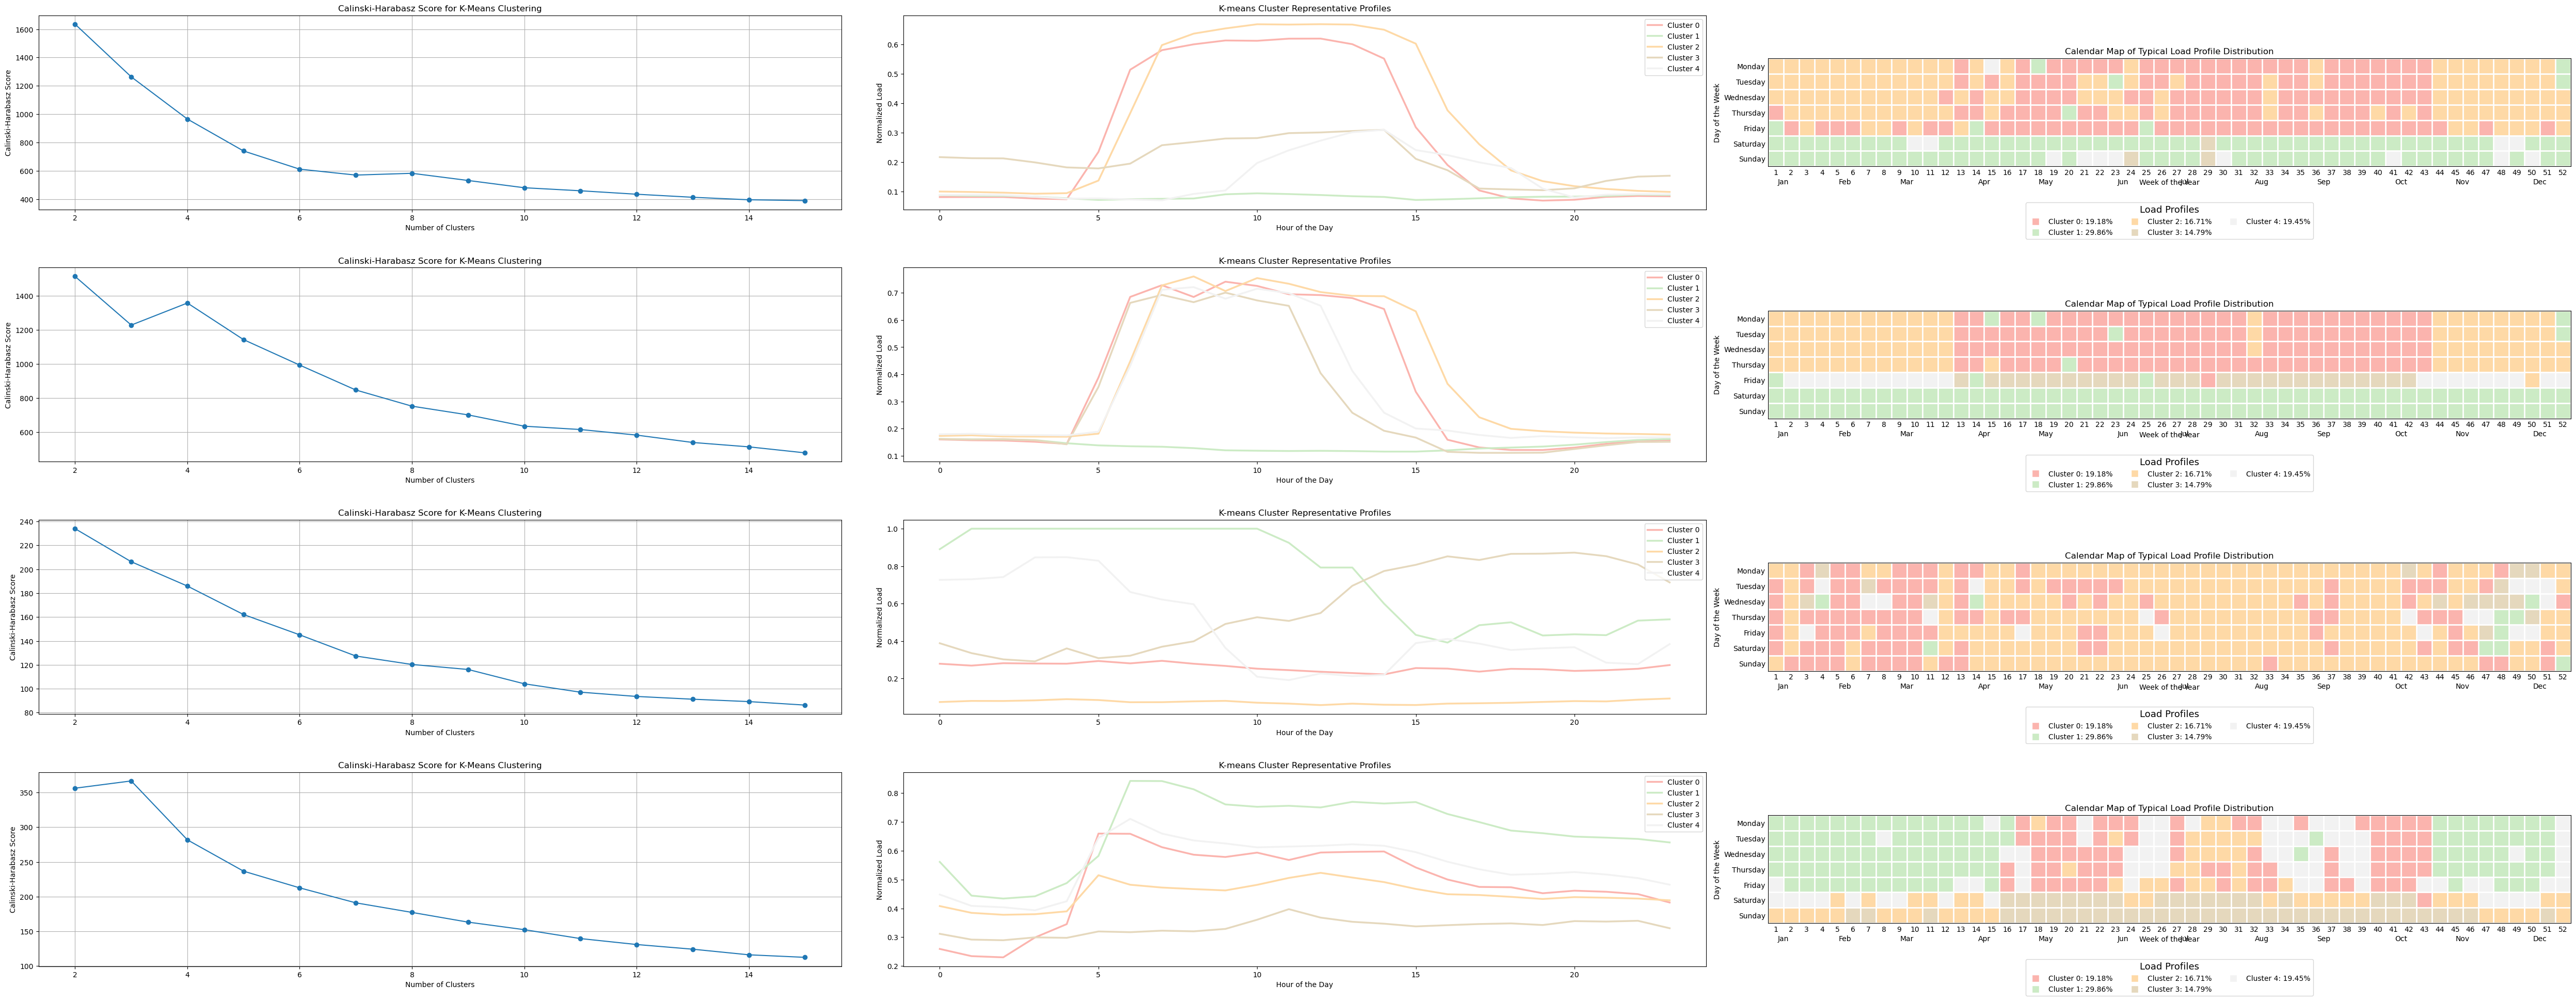

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans
import numpy as np

def analyze_energy_data(file_paths):
    results = []
    
    for file_path in file_paths:
        # Load the data
        data = pd.read_csv(file_path)

        # Reshape the data to have 365 rows and 24 columns
        data_pivot = data.pivot(index='Day', columns='Hour', values=data.columns[2])

        # Find the optimal number of clusters
        max_k = 15

        def find_optimal_clusters(data, max_k):
            scores = []
            for k in range(2, max_k + 1):
                kmeans = KMeans(n_clusters=k, random_state=42)
                labels = kmeans.fit_predict(data)
                score = calinski_harabasz_score(data, labels)
                scores.append(score)
            return scores

        scores = find_optimal_clusters(data_pivot.iloc[:, :24], max_k)
        
        # Determine the optimal number of clusters
        k_optimal = 5  # Chosen based on the elbow point in the plot

        # Apply k-means clustering with the optimal number of clusters
        kmeans = KMeans(n_clusters=k_optimal, random_state=42)
        data_pivot['Cluster_KMeans'] = kmeans.fit_predict(data_pivot.iloc[:, :24])

        # Calculate the mean load profile for each cluster
        kmeans_profiles = data_pivot.groupby('Cluster_KMeans').mean().iloc[:, :24]

        # Prepare the data for the calendar heatmap
        data_pivot['Date'] = pd.date_range(start='2023-01-01', periods=365)
        data_pivot['WeekOfYear'] = data_pivot['Date'].dt.isocalendar().week
        data_pivot['DayOfWeek'] = data_pivot['Date'].dt.dayofweek

        # Create a matrix for the heatmap
        heatmap_data = pd.pivot_table(data_pivot, values='Cluster_KMeans', index='DayOfWeek', columns='WeekOfYear')

        results.append((scores, kmeans_profiles, heatmap_data, k_optimal))

    # Plot the results
    num_files = len(file_paths)
    
    fig, axs = plt.subplots(num_files, 3, figsize=(50, 5 * num_files))

    for i, (scores, kmeans_profiles, heatmap_data, k_optimal) in enumerate(results):
        # Plot the Calinski-Harabasz scores
        axs[i, 0].plot(range(2, max_k + 1), scores, marker='o')
        axs[i, 0].set_title('Calinski-Harabasz Score for K-Means Clustering')
        axs[i, 0].set_xlabel('Number of Clusters')
        axs[i, 0].set_ylabel('Calinski-Harabasz Score')
        axs[i, 0].grid(True)

        # Plot the K-means cluster representative profiles with Pastel1 colormap
        colors = plt.cm.Pastel1(np.linspace(0, 1, k_optimal))
        for cluster in kmeans_profiles.index:
            axs[i, 1].plot(kmeans_profiles.columns, kmeans_profiles.loc[cluster], color=colors[cluster], label=f'Cluster {cluster}', linewidth=2.5)
        axs[i, 1].set_title('K-means Cluster Representative Profiles')
        axs[i, 1].set_xlabel('Hour of the Day')
        axs[i, 1].set_ylabel('Normalized Load')
        axs[i, 1].legend()

        # Generate the calendar heatmap with the specified requirements
        cmap = mcolors.ListedColormap(plt.cm.Pastel1(np.linspace(0, 1, k_optimal)))
        heatmap = axs[i, 2].imshow(heatmap_data, cmap=cmap, aspect='equal', interpolation='nearest')

        # Remove ticks but keep tick labels
        axs[i, 2].tick_params(axis='x', which='both', length=0)
        axs[i, 2].tick_params(axis='y', which='both', length=0)

        # Add horizontal and vertical grid lines
        axs[i, 2].set_xticks(np.arange(-.5, heatmap_data.shape[1], 1), minor=True)
        axs[i, 2].set_yticks(np.arange(-.5, heatmap_data.shape[0], 1), minor=True)
        axs[i, 2].grid(which='minor', color='white', linestyle='-', linewidth=2)
        axs[i, 2].tick_params(which='minor', size=0)

        # Remove other grid lines
        axs[i, 2].grid(False)

        # Set the labels and title
        axs[i, 2].set_title('Calendar Map of Typical Load Profile Distribution')
        axs[i, 2].set_xlabel('Week of the Year')
        axs[i, 2].set_ylabel('Day of the Week')

        # Set the y-axis labels to day names
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        axs[i, 2].set_yticks(np.arange(7))
        axs[i, 2].set_yticklabels(days)

        # Set the x-axis labels to week numbers
        weeks = np.arange(1, 53)
        axs[i, 2].set_xticks(np.arange(52))
        axs[i, 2].set_xticklabels(weeks)

        # Add month names below the weeks
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        month_positions = [0, 4, 8, 13, 17, 22, 26, 31, 35, 40, 44, 49]
        for pos, month in zip(month_positions, months):
            axs[i, 2].text(pos + 0.5, 7.5, month, ha='center', va='center')

        # Count the frequency of each cluster
        cluster_counts = data_pivot['Cluster_KMeans'].value_counts(normalize=True).sort_index()
        cluster_labels = [f"Cluster {i}: {cluster_counts[i]:.2%}" for i in cluster_counts.index]

        # Add legend with reduced size by 30%
        legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=cmap(i), markersize=10) for i in cluster_counts.index]
        axs[i, 2].legend(legend_handles, cluster_labels, title='Load Profiles', title_fontsize='13', fontsize='10', loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.3)

    plt.savefig('./Load_profiles/results_annual.pdf', bbox_inches='tight')
    plt.show()
    

# Example usage
file_paths = [
    './Load_profiles/annual_anläggning63.csv',
    './Load_profiles/annual_anläggning70.csv',
    './Load_profiles/annual_anläggning288.csv',
    './Load_profiles/annual_anläggning94.csv'
]

analyze_energy_data(file_paths)


In [163]:
df_replaced[70].to_csv('./Load_profiles/el_consumption70.csv')

In [253]:
from datetime import datetime, timedelta

# Load the electricity consumption data
consumption_file_path = './Load_profiles/el_consumption70.csv'  # Change this to the correct path
consumption_data = pd.read_csv(consumption_file_path)

# Load the electricity price data
price_file_path = './Load_profiles/elprice2023.csv'  # Change this to the correct path
price_data = pd.read_csv(price_file_path)

# Inspect the first few rows to understand the structure
print("Consumption Data Head:")
print(consumption_data.head())

print("Price Data Head:")
print(price_data.head())


start_date = datetime(2023, 1, 1)

consumption_data.reset_index(inplace=True)
price_data['Unnamed: 0'] = consumption_data['Day']
price_data['MTU (CET/CEST)'] = consumption_data['Hour']

consumption_data['Date'] = consumption_data['Day'].apply(
    lambda x: start_date + timedelta(days=x-1))
consumption_data.set_index(['Date', 'Hour'], inplace=True)
consumption_data.drop(['index', 'Day'], axis=1, inplace=True)

price_data.drop(['Currency', 'BZN|SE3'], axis=1, inplace=True)
price_data.rename(columns={'Unnamed: 0': 'Day', 'MTU (CET/CEST)': 'Hour'}, inplace=True)
price_data['Date'] = price_data['Day'].apply(lambda x: start_date + timedelta(days=x-1))
price_data.drop(['Day'], axis=1, inplace=True)
price_data.set_index(['Date', 'Hour'], inplace=True)

# Ensure both dataframes have the same index
consumption_data = consumption_data.sort_index()
price_data = price_data.sort_index()

consumption_data.columns = ['col']
price_data.columns = ['col']

# Convert the price unit from EUR/MWh into sek/kWh
price_data * 10 / 1000

# Calculate total energy consumption and cost for the original dataset
total_energy_consumed = consumption_data.sum().sum()
total_cost_original = (consumption_data * price_data).sum().sum()

# Create a copy of the consumption data and set all Fridays' consumption to zero
consumption_no_friday = consumption_data.copy()
# Extract the day of the week from the 'Day' index level, assuming 'Day' is in datetime format
fridays = consumption_no_friday.index.get_level_values('Date').dayofweek == 4  # Friday is day 4
consumption_no_friday.loc[fridays, :] = 0

# Calculate total energy consumption and cost for the modified dataset
total_energy_saved = total_energy_consumed - consumption_no_friday.sum().sum()
total_cost_no_Fridays = (consumption_no_friday * price_data).sum().sum()
total_cost_saved = total_cost_original - (consumption_no_friday * price_data).sum().sum()

print("Total energy saved (kWh):", total_energy_saved)
print('Total cost original (sek):', total_cost_original)
print('Total cost no Fridays (sek):', total_cost_no_Fridays)
print("Total cost saved (sek):", total_cost_saved)


Consumption Data Head:
   Day  Hour    70
0    1     0  6.16
1    1     1  6.32
2    1     2  6.37
3    1     3  6.42
4    1     4  6.22
Price Data Head:
   Unnamed: 0                       MTU (CET/CEST)  Day-ahead Price [EUR/MWh]  \
0           0  01.01.2023 00:00 - 01.01.2023 01:00                       2.01   
1           1  01.01.2023 01:00 - 01.01.2023 02:00                       1.38   
2           2  01.01.2023 02:00 - 01.01.2023 03:00                       0.09   
3           3  01.01.2023 03:00 - 01.01.2023 04:00                       0.08   
4           4  01.01.2023 04:00 - 01.01.2023 05:00                       0.05   

  Currency  BZN|SE3  
0      EUR      NaN  
1      EUR      NaN  
2      EUR      NaN  
3      EUR      NaN  
4      EUR      NaN  
Total energy saved (kWh): 12256.877999999982
Total cost original (sek): 5195399.190506036
Total cost no Fridays (sek): 4437401.232786035
Total cost saved (sek): 757997.9577200012


In [252]:
consumption_data.columns = ['col1']

In [249]:
price_data.columns = 'col1'

In [250]:
consumption_data * price_data

col1
Date       Hour           
2023-01-01 0      12.38160
           1       8.72160
           2       0.57330
           3       0.51360
           4       0.31100
...                    ...
2023-12-31 19    188.44856
           20    166.70442
           21    149.03600
           22    136.03915
           23    130.85690

[8760 rows x 1 columns]

In [ ]:
price